In [45]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, LineString, GeometryCollection
from shapely.ops import split
import math
import numpy as np
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
imd = gpd.read_file("input/IMD2018.zip")
df = imd.cx[1747618.6612:1768514.9720,5909569.6924:5922316.0159]
df = df[df.dhb2015_na == "Auckland"].copy()
df.set_index("DZ2018", inplace=True)
df.sample(1)

,Census_Pop,Count_MB18,dhb2015_co,dhb2015_na,ged2020num,ged2020nam,ta2020code,ta2020name,regc2020co,regc2020na,Rank_IMD18,Dec_IMD18,Rank_Emplo,Decile_Emp,Rank_Incom,Decile_Inc,Rank_Crime,Decile_Cri,Rank_Housi,Decile_Hou,Rank_Healt,Decile_Hea,Rank_Educa,Decile_Edu,Rank_Acces,Decile_Acc,RnkIMDNoEm,DecIMDNoEm,RnkIMDNoIn,DecIMDNoIn,RnkIMDNoCr,DecIMDNoCr,RnkIMDNoHo,DecIMDNoHo,RnkIMDNoHe,DecIMDNoHe,RnkIMDNoEd,DecIMDNoEd,RnkIMDNoAc,DecIMDNoAc,geometry
DZ2018,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7601071,618,7,3,Auckland,11,Epsom,76,Auckland,2,Auckland Region,1311,3,1954.5,4,1562,3,4683,8,3989,7,314,1,650,2,160,1,1191,2,1326,3,1110,2,1019,2,1694,3,1560,3,1457,3,"POLYGON ((1758982.768 5917851.730, 1758986.362..."


<Axes: >

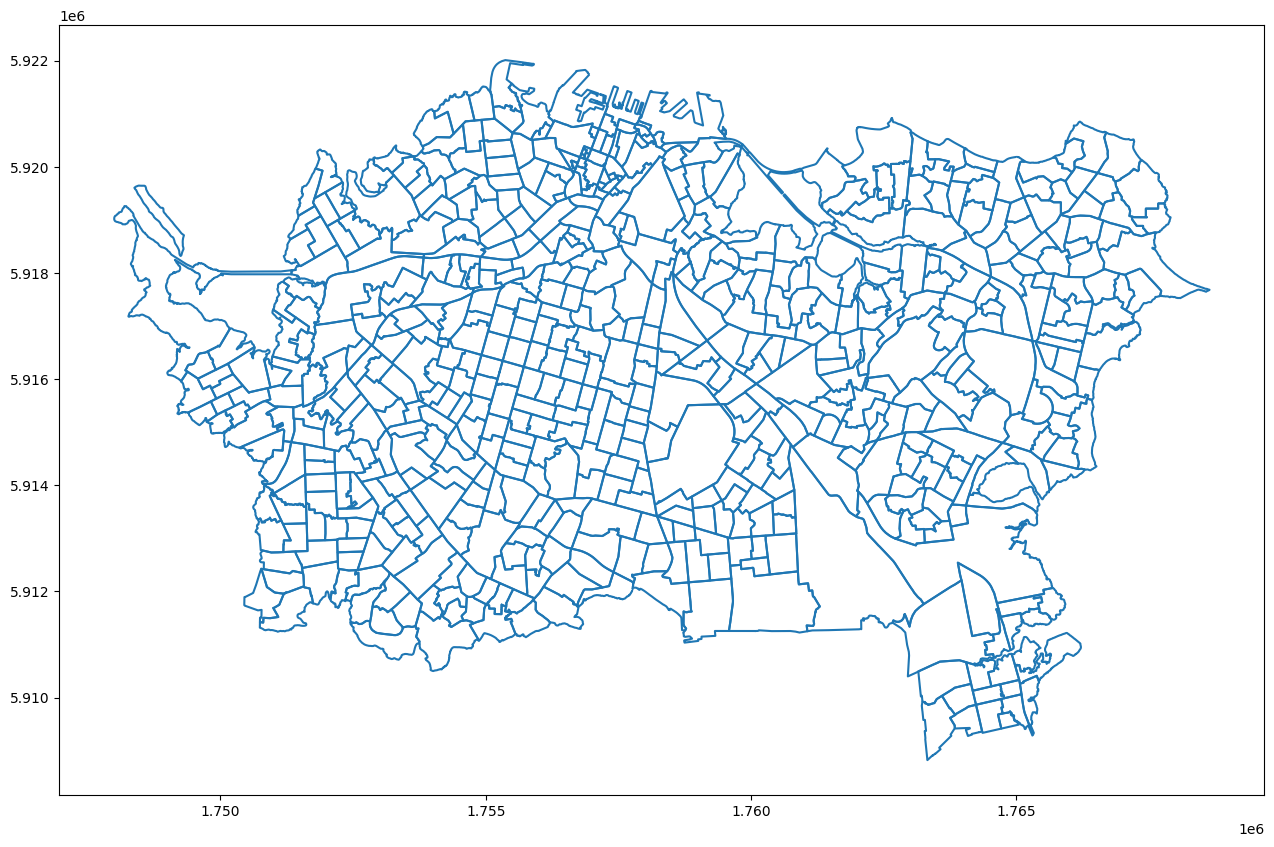

In [3]:
df.boundary.plot(figsize=(20,10))

Pull out one polygon to play with

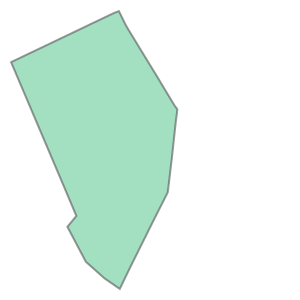

In [4]:
start = df.geometry.sample(1)
start_index = start.index[0]
start = start.iloc[0]
start

In [5]:
radius = start.centroid.distance(start.boundary)
radius

107.98635527540793

A hexagon is made of 6 equilateral triangles, with internal angles of 120 degrees. The internal angles of the equilateral triangles are all 60 degrees.

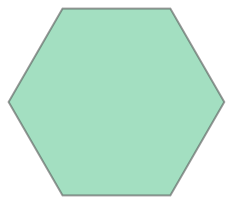

In [6]:
def create_hexagon(center, radius):
    """Create a hexagon centered at 'center' with a given 'radius', and include lines connecting each vertex to the center."""
    vertices = []
    for i in range(6):
        angle = math.radians(60 * i)  # Convert angle to radians
        x = center.x + radius * math.cos(angle)  # X-coordinate
        y = center.y + radius * math.sin(angle)  # Y-coordinate
        vertices.append((x, y))  # Append vertex coordinates
    hexagon = Polygon(vertices)  # Create a polygon from the vertices
    return hexagon

start_hexagon = create_hexagon(start.centroid, radius)
assert start_hexagon.is_valid
start_hexagon

In [7]:
df["hex_geo"] = gpd.GeoSeries()
df.loc[start_index, "hex_geo"] = start_hexagon

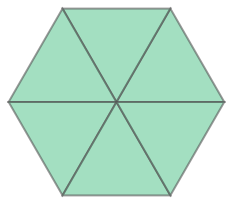

In [8]:
def hexagon_to_triangles(hexagon):
    center = hexagon.centroid
    vertices = list(hexagon.exterior.coords)
    triangles = []
    for i in range(6):
        next_i = (i + 1) % 6  # Wrap around to form a closed shape
        triangle = Polygon([center, vertices[i], vertices[next_i]])
        triangles.append(triangle)
    return GeometryCollection(triangles)

triangles = hexagon_to_triangles(start_hexagon)
assert triangles.is_valid
triangles

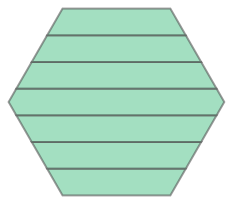

In [25]:
def slice_hexagon(hexagon, slices = 7):
  if hexagon is None:
    return None
  minx, miny, maxx, maxy = hexagon.bounds
  poly = hexagon
  segments = []
  slice_height = (maxy-miny) / slices
  for i in range(1, slices + 1):
    y = miny + slice_height * i
    parts = list(split(poly, LineString([(minx, y), (maxx, y)])).geoms)
    parts.sort(key=lambda p: p.bounds[1], reverse=True)
    #print(i, len(parts), [p.bounds[1] for p in parts], [p.area for p in parts])
    if len(parts) == 2:
      segments.append(parts[1])
      poly = parts[0]
    if i == slices:
      segments.append(parts[0])
  return GeometryCollection(segments)

slice_hexagon(start_hexagon)

<Axes: >

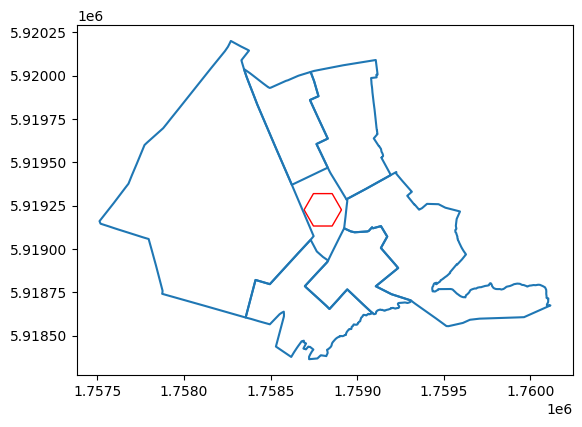

In [10]:
neighbours = df.geometry[df.touches(start)]
ax = neighbours.boundary.plot()
gpd.GeoSeries(start_hexagon).plot(ax=ax, edgecolor="red", facecolor="none")

In [11]:
angle = math.radians(60 / 2)
x = start.centroid.x + radius * 2 * math.cos(angle)
y = start.centroid.y + radius * 2 * math.sin(angle)
x, y

(1758988.3620705218, 5919333.8037704)

An equilateral triangle, split into two, makes two equal area triangles. The length of the line splitting the triangle, * 2, is the distance to the center of the neighbouring tesselated hexagon

93.51892693065207


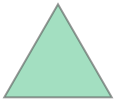

In [12]:
triangle = triangles.geoms[0]
v1, v2, v3 = set(triangle.exterior.coords)
midpoint = ((v1[0] + v2[0]) / 2, (v1[1] + v2[1]) / 2)
# Create a line from the midpoint to the opposite vertex
split_line = LineString([midpoint, v3])
print(split_line.length)
split_triangles = split(triangle, split_line)
split_triangles

In [13]:
radius, split_line.length * 2

(107.98635527540793, 187.03785386130414)

<Axes: >

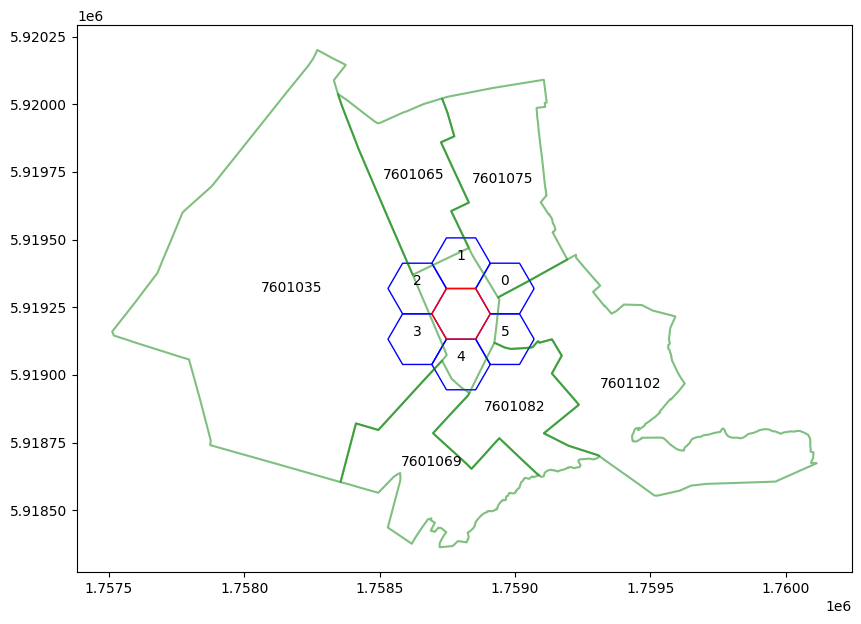

In [14]:
from shapely.geometry import Point
hex_neighbours = []
for i in range(6):
    angle = math.radians(60 * i + 30)  # Convert angle to radians
    x = start.centroid.x + split_line.length * 2 * math.cos(angle)  # X-coordinate
    y = start.centroid.y + split_line.length * 2 * math.sin(angle)  # Y-coordinate
    hex_neighbours.append(create_hexagon(Point([x, y]), radius))

hex_neighbours = gpd.GeoSeries(hex_neighbours, crs=df.crs)
ax = hex_neighbours.plot(edgecolor="blue", facecolor="none", figsize=(10,10))
for i in range(6):
  p = hex_neighbours.centroid.iloc[i]
  ax.annotate(text=str(i), xy=[p.x, p.y + radius / 8], ha='center')
neighbours.boundary.plot(ax=ax, color="green", alpha=.5)
for i in neighbours.index:
  ax.annotate(text=str(i), xy=[neighbours.centroid[i].x, neighbours.centroid[i].y], ha='center')
gpd.GeoSeries(start_hexagon).plot(ax=ax, edgecolor="red", facecolor="none")

                  0           1           2           3           4  \
DZ2018                                                                
7601035  787.304643  634.376794  463.432462  494.489696  679.657813   
7601065  525.621405  355.928582  403.793754  590.767586  706.115463   
7601069  708.330033  756.027827  656.887494  470.720345  389.526641   
7601075  389.953420  333.948956  501.801156  657.745132  687.873842   
7601082  452.710491  579.881177  577.732484  447.182373  262.024204   
7601102  591.116295  776.689487  869.035427  808.313369  632.093678   

                  5  
DZ2018               
7601035  805.977055  
7601065  679.878524  
7601069  540.192466  
7601075  576.964408  
7601082  266.728402  
7601102  497.560452  


<Axes: ylabel='DZ2018'>

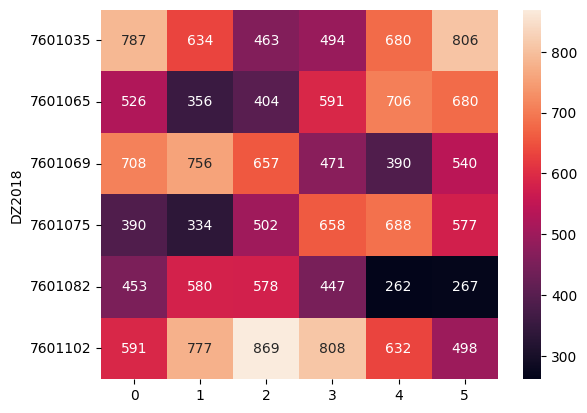

In [15]:
# Build a cost distance matrix
distance_matrix = neighbours.centroid.apply(lambda n: n.distance(hex_neighbours.centroid))
print(distance_matrix)
sns.heatmap(distance_matrix.round(), annot=True, fmt=".0f")

In [16]:
row_ind, col_ind = linear_sum_assignment(distance_matrix)
distance_matrix.index[row_ind], hex_neighbours[col_ind]
df.loc[distance_matrix.index[row_ind], "hex_geo"] = hex_neighbours[col_ind].values

In [38]:
df_hex = df[~df.hex_geo.isna()].copy()
df_hex

,Census_Pop,Count_MB18,dhb2015_co,dhb2015_na,ged2020num,ged2020nam,ta2020code,ta2020name,regc2020co,regc2020na,Rank_IMD18,Dec_IMD18,Rank_Emplo,Decile_Emp,Rank_Incom,Decile_Inc,Rank_Crime,Decile_Cri,Rank_Housi,Decile_Hou,Rank_Healt,Decile_Hea,Rank_Educa,Decile_Edu,Rank_Acces,Decile_Acc,RnkIMDNoEm,DecIMDNoEm,RnkIMDNoIn,DecIMDNoIn,RnkIMDNoCr,DecIMDNoCr,RnkIMDNoHo,DecIMDNoHo,RnkIMDNoHe,DecIMDNoHe,RnkIMDNoEd,DecIMDNoEd,RnkIMDNoAc,DecIMDNoAc,geometry,hex_geo,sliced_hexagons
DZ2018,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7601035,846,8,3,Auckland,1,Auckland Central,76,Auckland,2,Auckland Region,611,1,149.5,1,298,1,6045,10,2702,5,253,1,63,1,1563,3,976,2,877,2,64,1,537,1,873,2,841,2,705,2,"POLYGON ((1758654.066 5918969.695, 1758502.724...","POLYGON ((1758747.331 5919319.336, 1758693.338...",GEOMETRYCOLLECTION (POLYGON ((1758708.764 5919...
7601065,720,9,3,Auckland,11,Epsom,76,Auckland,2,Auckland Region,1112,2,414.5,1,1500,3,5752,10,4242,7,219,1,91,1,954,2,1564,3,1067,2,599,1,721,2,1463,3,1379,3,1236,2,"POLYGON ((1758487.923 5919932.308, 1758495.056...","POLYGON ((1758909.311 5919412.855, 1758855.317...",GEOMETRYCOLLECTION (POLYGON ((1758870.744 5919...
7601069,576,11,3,Auckland,11,Epsom,76,Auckland,2,Auckland Region,1764,3,1902.5,4,1124,2,5742,10,4714,8,1554,3,272,1,516,1,1861,4,2151,4,1315,3,1336,3,2011,4,2138,4,1903,4,"POLYGON ((1758737.340 5918827.884, 1758697.927...","POLYGON ((1758747.331 5919132.298, 1758693.338...",GEOMETRYCOLLECTION (POLYGON ((1758708.764 5919...
7601073,663,7,3,Auckland,11,Epsom,76,Auckland,2,Auckland Region,791,2,584.0,1,995,2,4300,7,4683,8,188,1,418,1,858,2,1080,2,859,2,650,2,304,1,1119,2,992,2,918,2,"POLYGON ((1758834.445 5918938.203, 1758832.034...","POLYGON ((1758909.311 5919225.817, 1758855.317...",GEOMETRYCOLLECTION (POLYGON ((1758870.744 5919...
7601075,1038,11,3,Auckland,11,Epsom,76,Auckland,2,Auckland Region,1389,3,2227.0,4,892,2,4504,8,3541,6,1832,3,853,2,1807,3,1143,2,1726,3,1229,2,1212,2,1509,3,1605,3,1481,3,"POLYGON ((1759111.402 5919698.495, 1759113.521...","POLYGON ((1759071.290 5919319.336, 1759017.297...",GEOMETRYCOLLECTION (POLYGON ((1759032.724 5919...
7601082,501,5,3,Auckland,11,Epsom,76,Auckland,2,Auckland Region,1268,3,1049.5,2,877,2,5425,9,4619,8,1414,3,386,1,752,2,1555,3,1551,3,900,2,784,2,1461,3,1556,3,1409,3,"POLYGON ((1759137.871 5919130.358, 1759151.610...","POLYGON ((1758909.311 5919038.780, 1758855.317...",GEOMETRYCOLLECTION (POLYGON ((1758870.744 5918...
7601102,798,14,3,Auckland,11,Epsom,76,Auckland,2,Auckland Region,182,1,488.0,1,276,1,3396,6,2378,4,614,1,88,1,1699,3,251,1,230,1,112,1,94,1,245,1,251,1,242,1,"POLYGON ((1759307.521 5919283.503, 1759330.815...","POLYGON ((1759071.290 5919132.298, 1759017.297...",GEOMETRYCOLLECTION (POLYGON ((1759032.724 5919...


In [41]:
rank_cols = ['Rank_Emplo', 'Rank_Incom', 'Rank_Crime', 'Rank_Housi', 'Rank_Healt', 'Rank_Educa', 'Rank_Acces']

In [39]:
df_hex["sliced_hexagons"] = df_hex.hex_geo.apply(slice_hexagon)

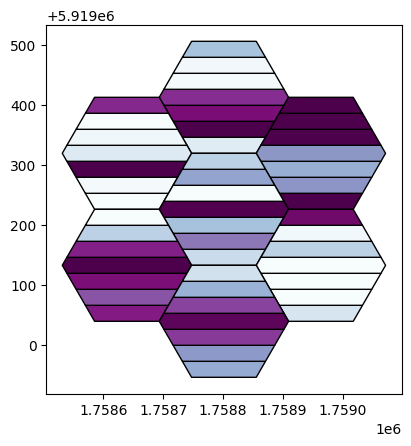

In [50]:
ax = plt.gca()
for i, rank_col in enumerate(rank_cols):
    df_hex.set_geometry(df_hex.sliced_hexagons.apply(lambda g: g.geoms[i])).plot(rank_col, ax=ax, cmap="BuPu", edgecolor="black")